In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, balanced_accuracy_score, f1_score, RocCurveDisplay
from imblearn.over_sampling import SMOTE
import lightgbm

In [2]:
label_dataset_2015 = pd.read_csv("/Users/seanathon48/Desktop/CS_534/Final_Project/archive/DRIAMS-A/id/2015/2015_clean.csv")
label_dataset_2016 = pd.read_csv("/Users/seanathon48/Desktop/CS_534/Final_Project/archive/DRIAMS-A/id/2016/2016_clean.csv")
label_dataset_2017 = pd.read_csv("/Users/seanathon48/Desktop/CS_534/Final_Project/archive/DRIAMS-A/id/2017/2017_clean.csv")
label_dataset_2018 = pd.read_csv("/Users/seanathon48/Desktop/CS_534/Final_Project/archive/DRIAMS-A/id/2018/2018_clean.csv")

/var/folders/v0/37fzp2hx3ns37mhx_9_xr5qh0000gn/T/ipykernel_77246/1115557230.py:3: DtypeWarning: Columns (71) have mixed types. Specify dtype option on import or set low_memory=False.
  label_dataset_2017 = pd.read_csv("/Users/seanathon48/Desktop/CS_534/Final_Project/archive/DRIAMS-A/id/2017/2017_clean.csv")


In [3]:
def preprocess_data(data_2015, data_2016, data_2017, data_2018, drug_name):
    data_2015 = data_2015.loc[data_2015['species'] == "Escherichia coli"]
    data_2016 = data_2016.loc[data_2016['species'] == "Escherichia coli"]
    data_2017 = data_2017.loc[data_2017['species'] == "Escherichia coli"]
    data_2018 = data_2018.loc[data_2018['species'] == "Escherichia coli"]
    
    only_drug_15 = data_2015[['code', drug_name]].dropna()
    only_drug_16 = data_2016[['code', drug_name]].dropna()
    only_drug_17 = data_2017[['code', drug_name]].dropna()
    only_drug_18 = data_2018[['code', drug_name]].dropna()
    
    print("Assembling 2015 DRIAMS data...")
    starting_dataset_15 = np.zeros((only_drug_15.shape[0], 6000))
    base_path = "/Users/seanathon48/Desktop/CS_534/Final_Project/archive/DRIAMS-A/binned_6000/2015/"
    for i in range(only_drug_15.shape[0]):
        starting_dataset_15[i] = np.loadtxt(base_path + only_drug_15.iloc[i]["code"] + ".txt", skiprows = 1, usecols = 1)
    
    print("Assembling 2016 DRIAMS data...")
    starting_dataset_16 = np.zeros((only_drug_16.shape[0], 6000))
    base_path = "/Users/seanathon48/Desktop/CS_534/Final_Project/archive/DRIAMS-A/binned_6000/2016/"
    for i in range(only_drug_16.shape[0]):
        starting_dataset_16[i] = np.loadtxt(base_path + only_drug_16.iloc[i]["code"] + ".txt", skiprows = 1, usecols = 1)

    print("Assembling 2017 DRIAMS data...")        
    starting_dataset_17 = np.zeros((only_drug_17.shape[0], 6000))
    base_path = "/Users/seanathon48/Desktop/CS_534/Final_Project/archive/DRIAMS-A/binned_6000/2017/"
    for i in range(only_drug_17.shape[0]):
        starting_dataset_17[i] = np.loadtxt(base_path + only_drug_17.iloc[i]["code"] + ".txt", skiprows = 1, usecols = 1)
        
    print("Assembling 2018 DRIAMS data...")
    starting_dataset_18 = np.zeros((only_drug_18.shape[0], 6000))
    base_path = "/Users/seanathon48/Desktop/CS_534/Final_Project/archive/DRIAMS-A/binned_6000/2018/"
    for i in range(only_drug_18.shape[0]):
        starting_dataset_18[i] = np.loadtxt(base_path + only_drug_18.iloc[i]["code"] + ".txt", skiprows = 1, usecols = 1)
        
    e_coli_numpy_15 = np.hstack((starting_dataset_15, np.array(only_drug_15[drug_name]).reshape(only_drug_15.shape[0], 1)))
    e_coli_numpy_16 = np.hstack((starting_dataset_16, np.array(only_drug_16[drug_name]).reshape(only_drug_16.shape[0], 1)))
    e_coli_numpy_17 = np.hstack((starting_dataset_17, np.array(only_drug_17[drug_name]).reshape(only_drug_17.shape[0], 1)))
    e_coli_numpy_18 = np.hstack((starting_dataset_18, np.array(only_drug_18[drug_name]).reshape(only_drug_18.shape[0], 1)))
    
    e_coli_numpy = np.vstack((e_coli_numpy_15, e_coli_numpy_16, e_coli_numpy_17, e_coli_numpy_18))
    
    column_list = []
    for i in range(1, 6001):
        column_list.append("Bin " + str(i))
    column_list.append("Class")
    
    e_coli_df = pd.DataFrame(e_coli_numpy, columns = column_list)
    
    e_coli_df = e_coli_df[(e_coli_df['Class'] == "S") | (e_coli_df['Class'] == "R")]
    
    e_coli_df_X = e_coli_df.iloc[:,:-1]
    e_coli_df_y = e_coli_df.iloc[:,-1]
    
    e_coli_df_X = e_coli_df_X.astype(np.float64)
    e_coli_df_y[e_coli_df_y == "S"] = 0
    e_coli_df_y[e_coli_df_y == "R"] = 1
    e_coli_df_y = e_coli_df_y.astype(np.int64)
    
    return e_coli_df_X, e_coli_df_y

In [23]:
e_coli_df_X, e_coli_df_y = preprocess_data(label_dataset_2015, label_dataset_2016, 
                                        label_dataset_2017, label_dataset_2018, "Ciprofloxacin")

Assembling 2015 DRIAMS data...
Assembling 2016 DRIAMS data...
Assembling 2017 DRIAMS data...
Assembling 2018 DRIAMS data...


In [24]:
regular_lightgbm = lightgbm.LGBMClassifier(objective="binary", seed=48, boosting_type='gbdt', learning_rate=0.05, n_estimators=40)
selector = RFE(regular_lightgbm, step=10, verbose=99, n_features_to_select = 20)
feature_selected_e_coli_df_X = selector.fit_transform(e_coli_df_X, e_coli_df_y)

Fitting estimator with 6000 features.
Fitting estimator with 5990 features.
Fitting estimator with 5980 features.
Fitting estimator with 5970 features.
Fitting estimator with 5960 features.
Fitting estimator with 5950 features.
Fitting estimator with 5940 features.
Fitting estimator with 5930 features.
Fitting estimator with 5920 features.
Fitting estimator with 5910 features.
Fitting estimator with 5900 features.
Fitting estimator with 5890 features.
Fitting estimator with 5880 features.
Fitting estimator with 5870 features.
Fitting estimator with 5860 features.
Fitting estimator with 5850 features.
Fitting estimator with 5840 features.
Fitting estimator with 5830 features.
Fitting estimator with 5820 features.
Fitting estimator with 5810 features.
Fitting estimator with 5800 features.
Fitting estimator with 5790 features.
Fitting estimator with 5780 features.
Fitting estimator with 5770 features.
Fitting estimator with 5760 features.
Fitting estimator with 5750 features.
Fitting esti

In [25]:
feature_selected_e_coli_df_X.shape

(4816, 20)

In [26]:
# No SMOTE, No Feature Selection
print("No SMOTE, No Feature Selection...")
without_fs_roc = []
without_fs_acc = []
without_fs_f1 = []
fs_lightgbm = lightgbm.LGBMClassifier(objective="binary", seed=42, boosting_type='gbdt', learning_rate=0.05, n_estimators=125)
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
fold_count = 1
for train_index, test_index in skf.split(e_coli_df_X, e_coli_df_y):
    print(f"Evaluating Fold {fold_count}/5...")
    X_train, X_test = e_coli_df_X.iloc[train_index], e_coli_df_X.iloc[test_index]
    y_train, y_test = e_coli_df_y.iloc[train_index], e_coli_df_y.iloc[test_index]
    _ = fs_lightgbm.fit(X_train, y_train)#, eval_set = (e_coli_df_X_val, e_coli_df_y_val), callbacks = [lightgbm.early_stopping(50)])
    y_pred = fs_lightgbm.predict(X_test)
    without_fs_roc.append(roc_auc_score(y_test, y_pred))
    without_fs_acc.append(accuracy_score(y_test, y_pred))
    without_fs_f1.append(f1_score(y_test, y_pred))
    # print("ROC:", roc_auc_score(y_test, y_pred))
    # print("ACC:", accuracy_score(y_test, y_pred))
    # print("F1:", f1_score(y_test, y_pred))
    fold_count += 1
    
# SMOTE, No Feature Selection
print("SMOTE, No Feature Selection...")
just_smote_roc = []
just_smote_acc = []
just_smote_f1 = []
just_smote_lightgbm = lightgbm.LGBMClassifier(objective="binary", seed=42, boosting_type='gbdt', learning_rate=0.05, n_estimators=125)
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
fold_count = 1
for train_index, test_index in skf.split(e_coli_df_X, e_coli_df_y):
    print(f"Evaluating Fold {fold_count}/5...")
    X_train, X_test = e_coli_df_X.iloc[train_index], e_coli_df_X.iloc[test_index]
    y_train, y_test = e_coli_df_y.iloc[train_index], e_coli_df_y.iloc[test_index]
    X_train_resampled, y_train_resampled = SMOTE(random_state=42).fit_resample(X_train, y_train)
    _ = just_smote_lightgbm.fit(X_train_resampled, y_train_resampled)#, eval_set = (e_coli_df_X_val, e_coli_df_y_val), callbacks = [lightgbm.early_stopping(50)])
    y_pred = just_smote_lightgbm.predict(X_test)
    just_smote_roc.append(roc_auc_score(y_test, y_pred))
    just_smote_acc.append(accuracy_score(y_test, y_pred))
    just_smote_f1.append(f1_score(y_test, y_pred))
    # print("ROC:", roc_auc_score(y_test, y_pred))
    # print("ACC:", accuracy_score(y_test, y_pred))
    # print("F1:", f1_score(y_test, y_pred))
    fold_count += 1

# No SMOTE, Feature Selection
print("No SMOTE, Feature Selection...")
with_fs_roc = []
with_fs_acc = []
with_fs_f1 = []
super_final_fs_e_coli_X = e_coli_df_X.iloc[:,np.argsort(selector.ranking_)[1:23]]
fs_lightgbm = lightgbm.LGBMClassifier(objective="binary", seed=42, boosting_type='gbdt', learning_rate=0.05, n_estimators=125)
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
fold_count = 1
for train_index, test_index in skf.split(super_final_fs_e_coli_X, e_coli_df_y):
    print(f"Evaluating Fold {fold_count}/5...")
    X_train, X_test = super_final_fs_e_coli_X.iloc[train_index], super_final_fs_e_coli_X.iloc[test_index]
    y_train, y_test = e_coli_df_y.iloc[train_index], e_coli_df_y.iloc[test_index]
    _ = fs_lightgbm.fit(X_train, y_train)#, eval_set = (e_coli_df_X_val, e_coli_df_y_val), callbacks = [lightgbm.early_stopping(50)])
    y_pred = fs_lightgbm.predict(X_test)
    with_fs_roc.append(roc_auc_score(y_test, y_pred))
    with_fs_acc.append(accuracy_score(y_test, y_pred))
    with_fs_f1.append(f1_score(y_test, y_pred))
    # print("ROC:", roc_auc_score(y_test, y_pred))
    # print("ACC:", accuracy_score(y_test, y_pred))
    # print("F1:", f1_score(y_test, y_pred))
    fold_count += 1

# SMOTE, Feature Selection
print("SMOTE, Feature Selection...")
smote_fs_roc = []
smote_fs_acc = []
smote_fs_f1 = []
super_final_fs_e_coli_X = e_coli_df_X.iloc[:,np.argsort(selector.ranking_)[1:23]]
smote_fs_lightgbm = lightgbm.LGBMClassifier(objective="binary", seed=42, boosting_type='gbdt', learning_rate=0.05, n_estimators=125)
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
fold_count = 1
for train_index, test_index in skf.split(super_final_fs_e_coli_X, e_coli_df_y):
    print(f"Evaluating Fold {fold_count}/5...")
    X_train, X_test = super_final_fs_e_coli_X.iloc[train_index], super_final_fs_e_coli_X.iloc[test_index]
    y_train, y_test = e_coli_df_y.iloc[train_index], e_coli_df_y.iloc[test_index]
    X_train_resampled, y_train_resampled = SMOTE(random_state=42).fit_resample(X_train, y_train)
    _ = smote_fs_lightgbm.fit(X_train_resampled, y_train_resampled)#, eval_set = (e_coli_df_X_val, e_coli_df_y_val), callbacks = [lightgbm.early_stopping(50)])
    y_pred = smote_fs_lightgbm.predict(X_test)
    smote_fs_roc.append(roc_auc_score(y_test, y_pred))
    smote_fs_acc.append(accuracy_score(y_test, y_pred))
    smote_fs_f1.append(f1_score(y_test, y_pred))
    # print("ROC:", roc_auc_score(y_test, y_pred))
    # print("ACC:", accuracy_score(y_test, y_pred))
    # print("F1:", f1_score(y_test, y_pred))
    fold_count += 1

No SMOTE, No Feature Selection...
Evaluating Fold 1/5...
Evaluating Fold 2/5...
Evaluating Fold 3/5...
Evaluating Fold 4/5...
Evaluating Fold 5/5...
SMOTE, No Feature Selection...
Evaluating Fold 1/5...
Evaluating Fold 2/5...
Evaluating Fold 3/5...
Evaluating Fold 4/5...
Evaluating Fold 5/5...
No SMOTE, Feature Selection...
Evaluating Fold 1/5...
Evaluating Fold 2/5...
Evaluating Fold 3/5...
Evaluating Fold 4/5...
Evaluating Fold 5/5...
SMOTE, Feature Selection...
Evaluating Fold 1/5...
Evaluating Fold 2/5...
Evaluating Fold 3/5...
Evaluating Fold 4/5...
Evaluating Fold 5/5...


In [27]:
without_fs_roc

[0.7283968861327352,
 0.6971438560062716,
 0.716138908605511,
 0.6997367389531004,
 0.7175902874153803]

In [28]:
just_smote_roc

[0.7506214540176804,
 0.7034711260368883,
 0.743990550146727,
 0.7144624071700232,
 0.7435959234265253]

In [29]:
with_fs_roc

[0.745868848132999,
 0.7304063860667636,
 0.7304487620904092,
 0.7169705380695602,
 0.7315902662273686]

In [30]:
smote_fs_roc

[0.7619606808286054,
 0.7566450902079603,
 0.7246088163317195,
 0.7544256459695104,
 0.7456961850984714]

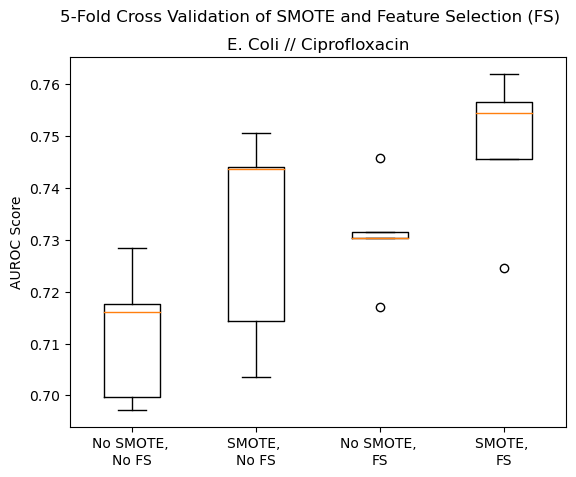

In [31]:
plt.boxplot([without_fs_roc, just_smote_roc, with_fs_roc, smote_fs_roc])
plt.xticks([1, 2, 3, 4], ['No SMOTE, \nNo FS', 'SMOTE, \nNo FS', 'No SMOTE, \nFS', 'SMOTE, \nFS'])
plt.ylabel("AUROC Score")
plt.suptitle("5-Fold Cross Validation of SMOTE and Feature Selection (FS)")
plt.title("E. Coli // Ciprofloxacin")
plt.savefig("5cv_smotefs_ecoli_ciprofloxacin.png")
plt.show()